In [1]:
import pandas as pd 
import pickle
import optuna
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import root_mean_squared_error, r2_score, d2_pinball_score,mean_absolute_error, mean_absolute_percentage_error

SEED=42

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

c:\Users\faceru\OneDrive - SAS\Documents\Personal\Italy_House_Prices\house_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('../data/modelling_data/train.csv')
valid = pd.read_csv('../data/modelling_data/valid.csv')

with open('artifacts/lightgbm_reg/quantile_lightgbm.pkl', 'rb') as fp:
    quantile_lightgbm = pickle.load(fp)
    
with open('artifacts/xgboost_reg/quantile_xgboost.pkl', 'rb') as fp:
    quantile_xgboost = pickle.load(fp)

In [3]:
def get_evaluation_metrics(y_true, y_pred, alpha=0.5):
    print('RMSE:', round(root_mean_squared_error(y_true=y_true, y_pred=y_pred),2))
    print('MAE:', round(mean_absolute_error(y_true=y_true, y_pred=y_pred),2))
    print('R2:', f'{round(100*r2_score(y_true=y_true, y_pred=y_pred),2)}%')
    print('Pinball Score', f'{round(100*d2_pinball_score(y_true=y_true, y_pred=y_pred, alpha=alpha),2)}%')
    print('MAPE:', f'{round(100*mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred),2)}%')
    
def coverage_fraction(y, y_low, y_high):
    print('Coverage Fraction:', f'{round(100*np.mean(np.logical_and(y >= y_low, y <= y_high)),2)}%')

In [4]:
features = train.select_dtypes(include=[np.number, bool]).columns
features = [i for i in features if i not in ['prezzo', 'log_prezzo', 'log_m2'] and 'emb_' not in i]
target='prezzo'

### LightGBM

In [5]:
q_05_lightgbm_pred = quantile_lightgbm['lightgbm_q0.05']['model'].predict(valid[features])
q_50_lightgbm_pred = quantile_lightgbm['lightgbm_q0.5']['model'].predict(valid[features])
q_95_lightgbm_pred = quantile_lightgbm['lightgbm_q0.95']['model'].predict(valid[features])

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


In [6]:
get_evaluation_metrics(valid[target], q_50_lightgbm_pred)

RMSE: 156445.25
MAE: 91698.09
R2: 74.38%
Pinball Score 53.57%
MAPE: 27.13%


In [7]:
coverage_fraction(valid[target], q_05_lightgbm_pred, q_95_lightgbm_pred)

Coverage Fraction: 85.42%


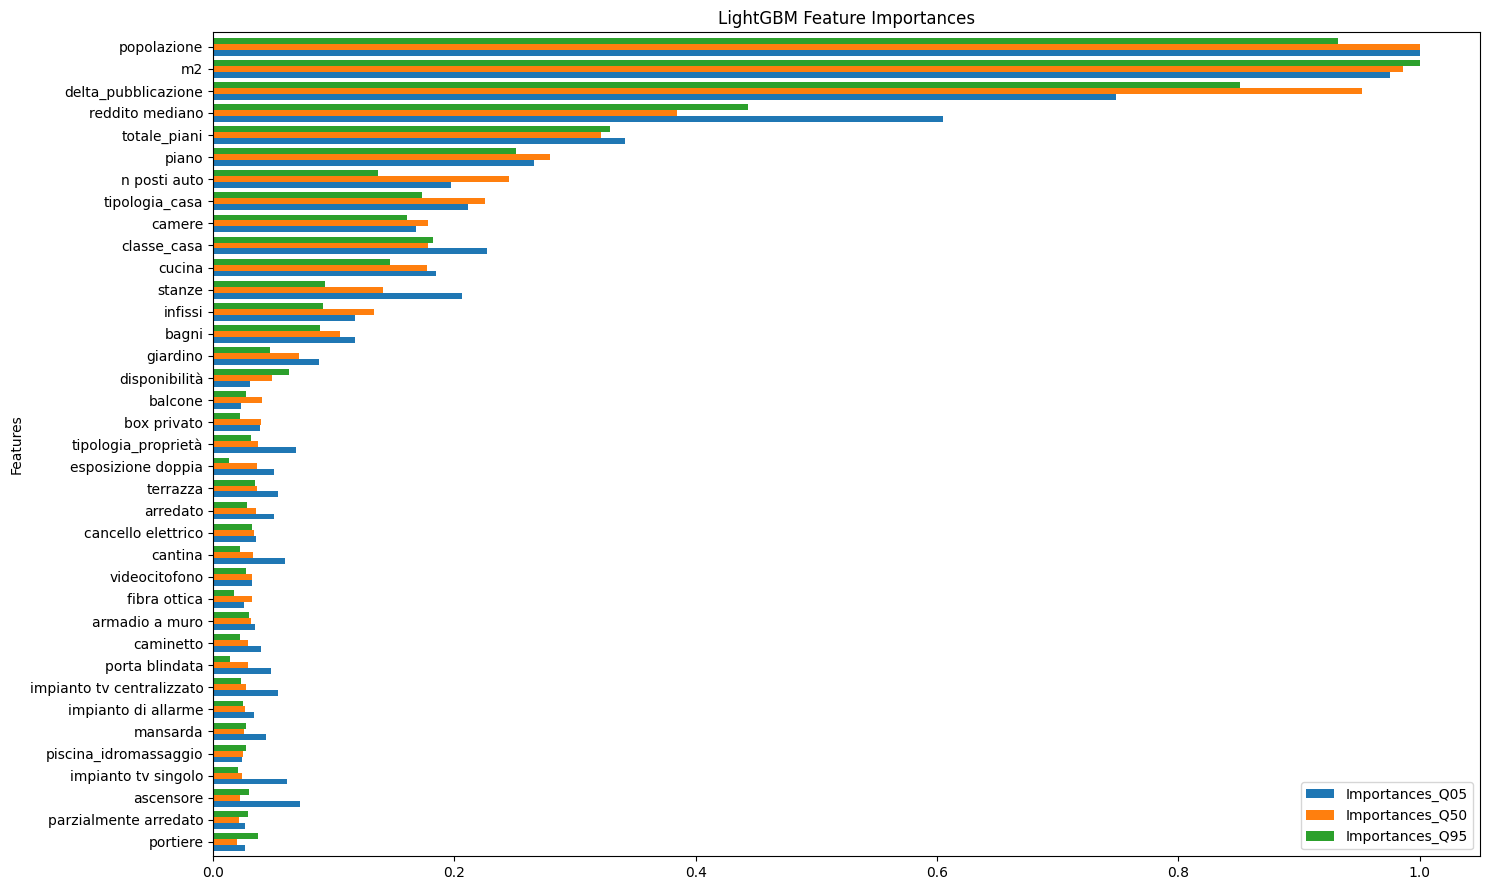

In [8]:
lightgbm_feature_imp = pd.DataFrame({'Features':features, 
                                     'Importances_Q05':quantile_lightgbm['lightgbm_q0.05']['model'].feature_importances_,
                                     'Importances_Q50':quantile_lightgbm['lightgbm_q0.5']['model'].feature_importances_,
                                     'Importances_Q95':quantile_lightgbm['lightgbm_q0.95']['model'].feature_importances_,}).sort_values('Importances_Q50')
lightgbm_feature_imp['Importances_Q05']/=lightgbm_feature_imp['Importances_Q05'].max()
lightgbm_feature_imp['Importances_Q50']/=lightgbm_feature_imp['Importances_Q50'].max()
lightgbm_feature_imp['Importances_Q95']/=lightgbm_feature_imp['Importances_Q95'].max()
fig, ax = plt.subplots(figsize=(15,9))
lightgbm_feature_imp.plot.barh(x='Features', y=['Importances_Q05', 'Importances_Q50', 'Importances_Q95'], ax=ax, width=0.8)
ax.set_title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

SHAP Values Q05


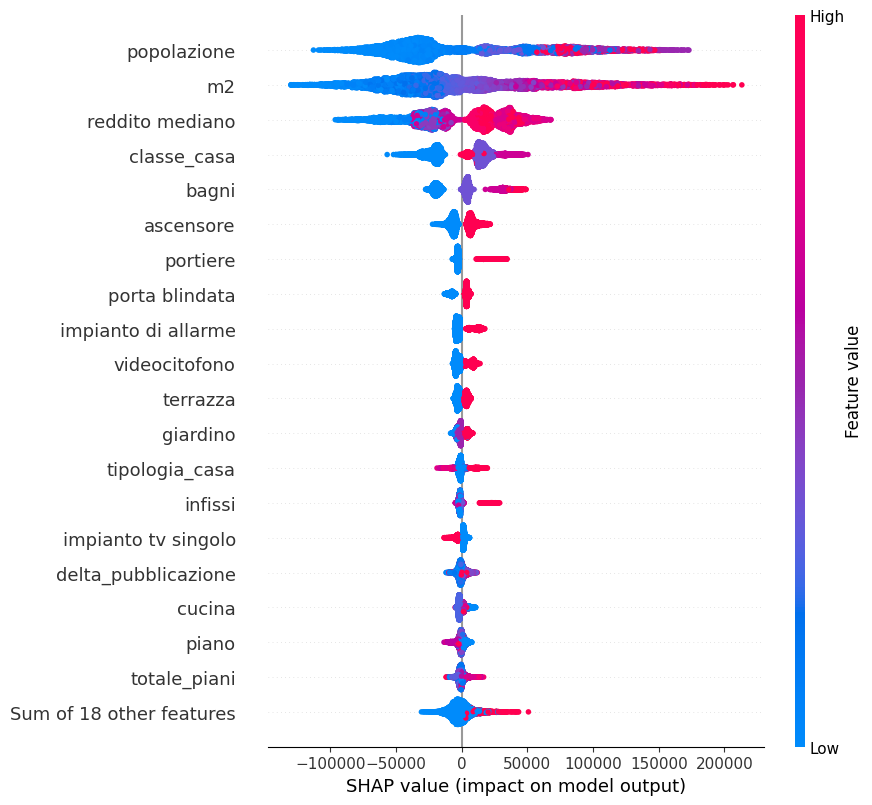

In [9]:
explainer = shap.Explainer(quantile_lightgbm['lightgbm_q0.05']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q05')
shap.plots.beeswarm(shap_values, max_display=20)

SHAP Values Q50


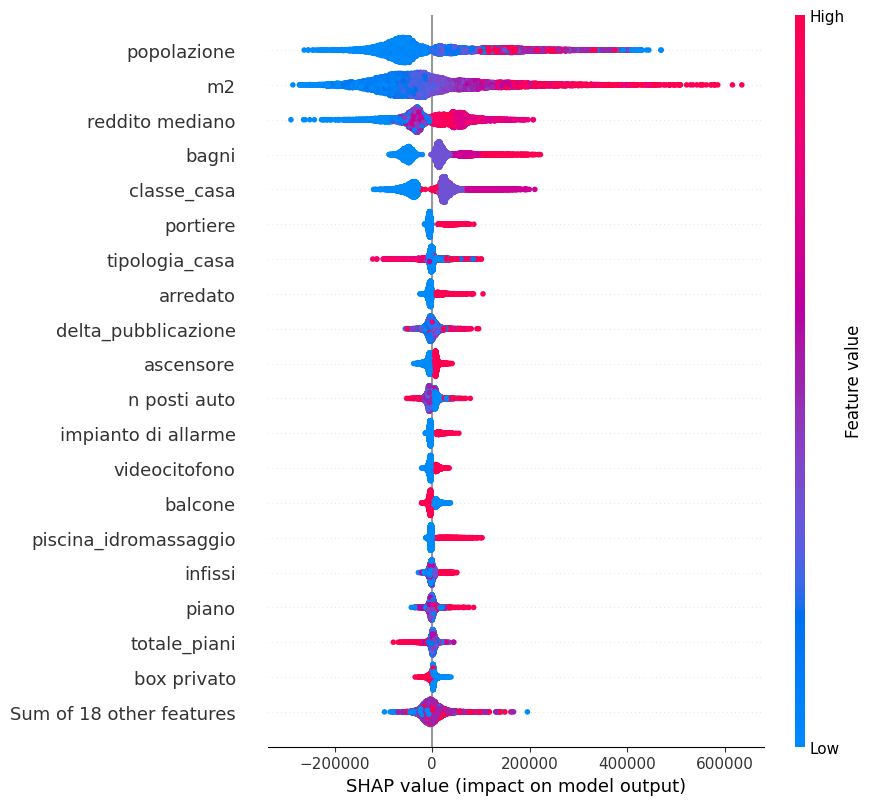

In [10]:
explainer = shap.Explainer(quantile_lightgbm['lightgbm_q0.5']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q50')
shap.plots.beeswarm(shap_values, max_display=20)

SHAP Values Q95


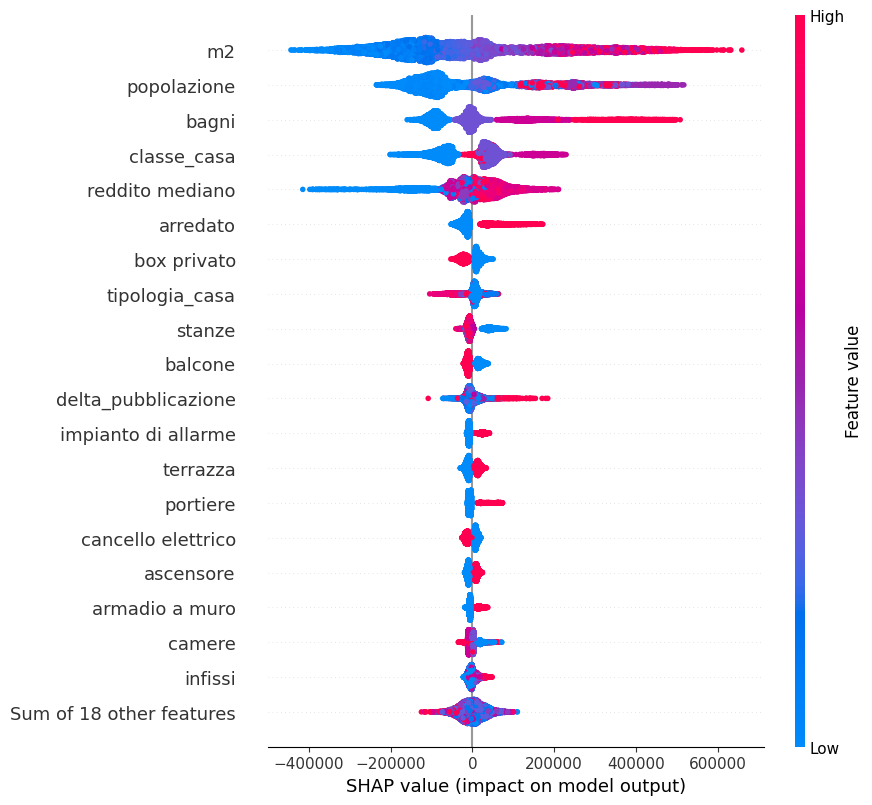

In [11]:
explainer = shap.Explainer(quantile_lightgbm['lightgbm_q0.95']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q95')
shap.plots.beeswarm(shap_values, max_display=20)

### XGBoost

In [12]:
q_05_xgboost_pred = quantile_xgboost['xgboost_q0.05']['model'].predict(valid[features])
q_50_xgboost_pred = quantile_xgboost['xgboost_q0.5']['model'].predict(valid[features])
q_95_xgboost_pred = quantile_xgboost['xgboost_q0.95']['model'].predict(valid[features])

In [13]:
get_evaluation_metrics(valid[target], q_50_xgboost_pred)

RMSE: 158692.01
MAE: 92578.32
R2: 73.64%
Pinball Score 53.13%
MAPE: 27.3%


In [14]:
coverage_fraction(valid[target], q_05_xgboost_pred, q_95_xgboost_pred)

Coverage Fraction: 83.81%


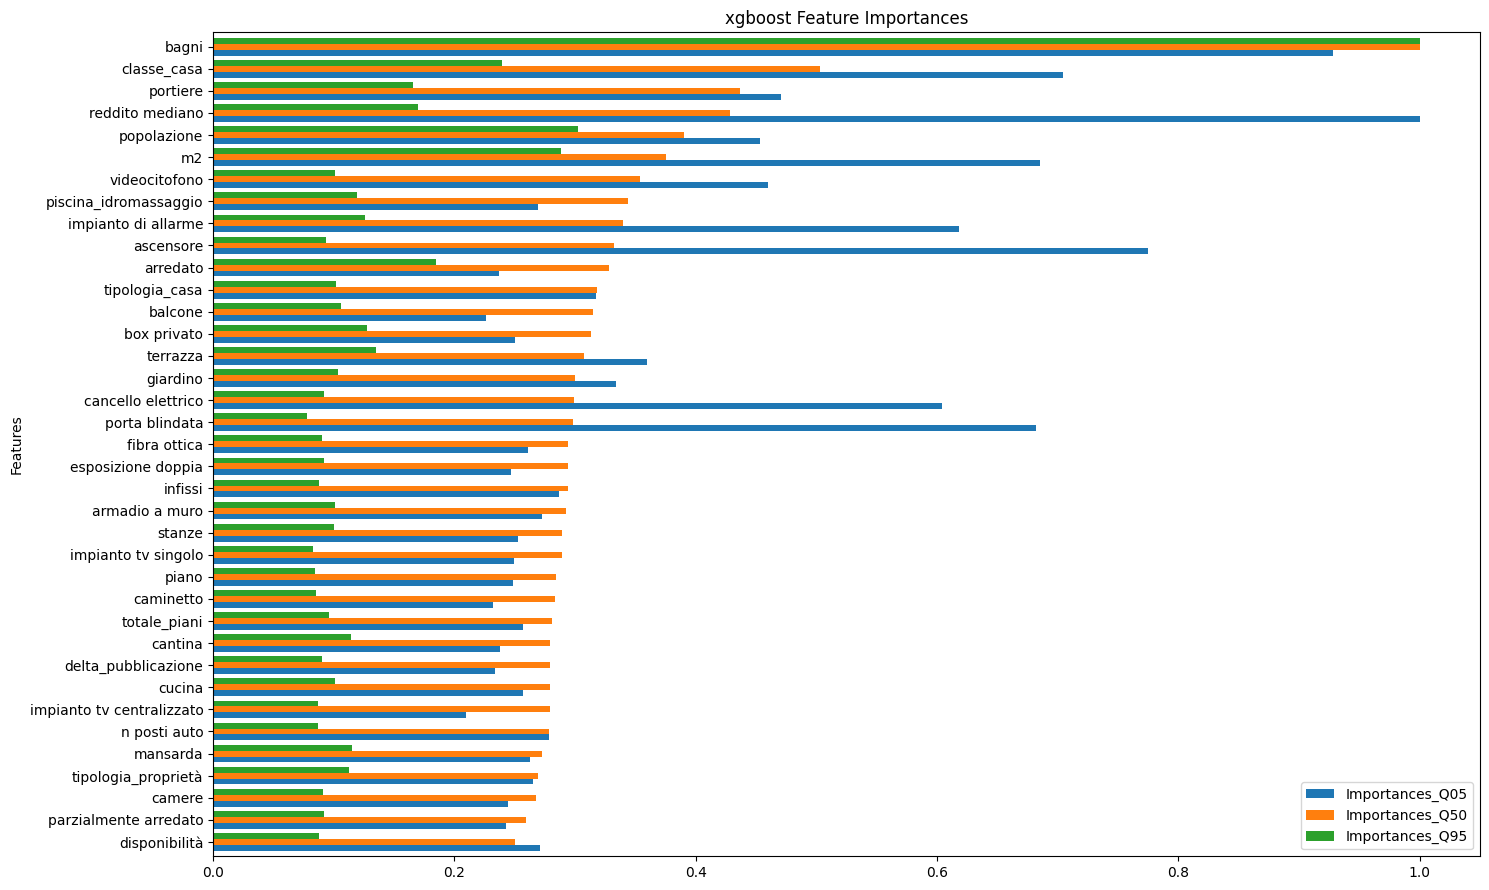

In [15]:
xgboost_feature_imp = pd.DataFrame({'Features':features, 
                                     'Importances_Q05':quantile_xgboost['xgboost_q0.05']['model'].feature_importances_,
                                     'Importances_Q50':quantile_xgboost['xgboost_q0.5']['model'].feature_importances_,
                                     'Importances_Q95':quantile_xgboost['xgboost_q0.95']['model'].feature_importances_,}).sort_values('Importances_Q50')
xgboost_feature_imp['Importances_Q05']/=xgboost_feature_imp['Importances_Q05'].max()
xgboost_feature_imp['Importances_Q50']/=xgboost_feature_imp['Importances_Q50'].max()
xgboost_feature_imp['Importances_Q95']/=xgboost_feature_imp['Importances_Q95'].max()
fig, ax = plt.subplots(figsize=(15,9))
xgboost_feature_imp.plot.barh(x='Features', y=['Importances_Q05', 'Importances_Q50', 'Importances_Q95'], ax=ax, width=0.8)
ax.set_title('xgboost Feature Importances')
plt.tight_layout()
plt.show()

SHAP Values Q05


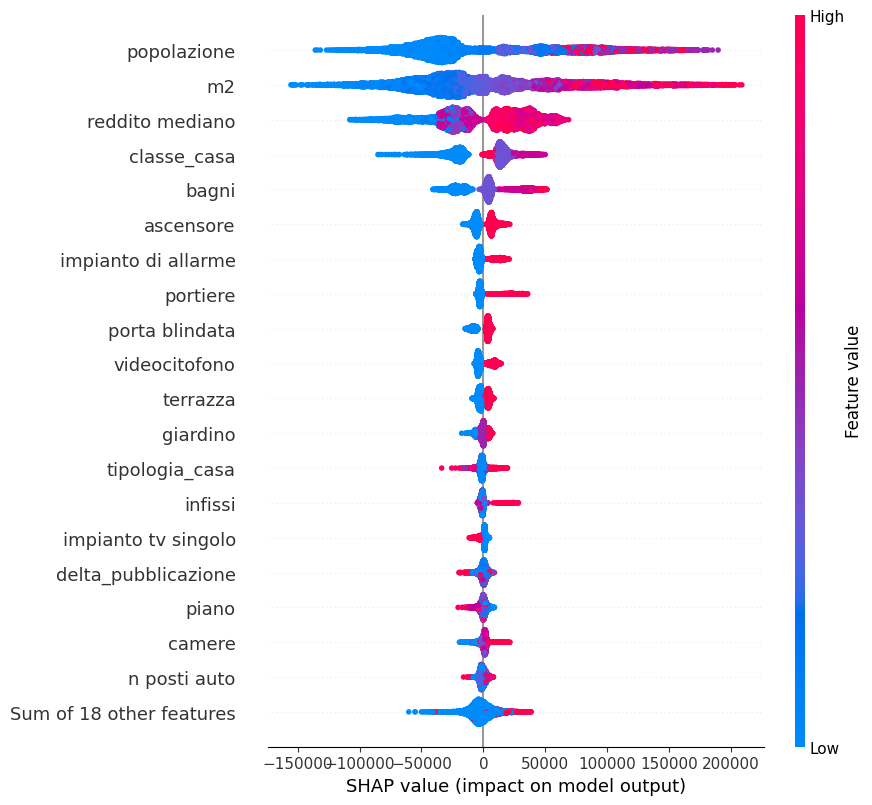

In [16]:
explainer = shap.Explainer(quantile_xgboost['xgboost_q0.05']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q05')
shap.plots.beeswarm(shap_values, max_display=20)

SHAP Values Q50


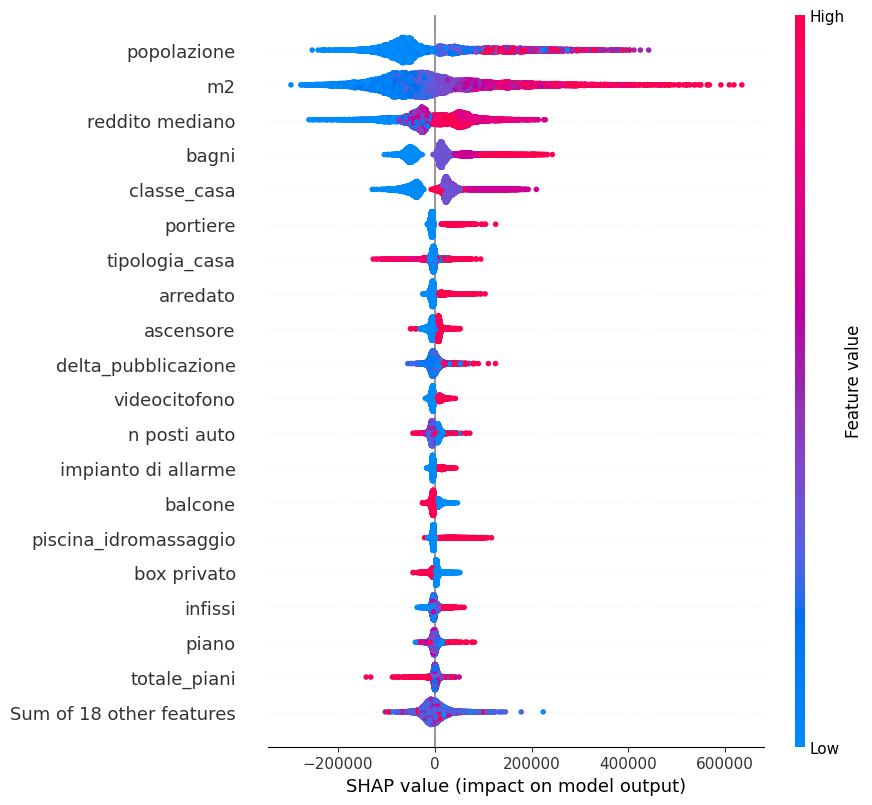

In [17]:
explainer = shap.Explainer(quantile_xgboost['xgboost_q0.5']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q50')
shap.plots.beeswarm(shap_values, max_display=20)

SHAP Values Q95


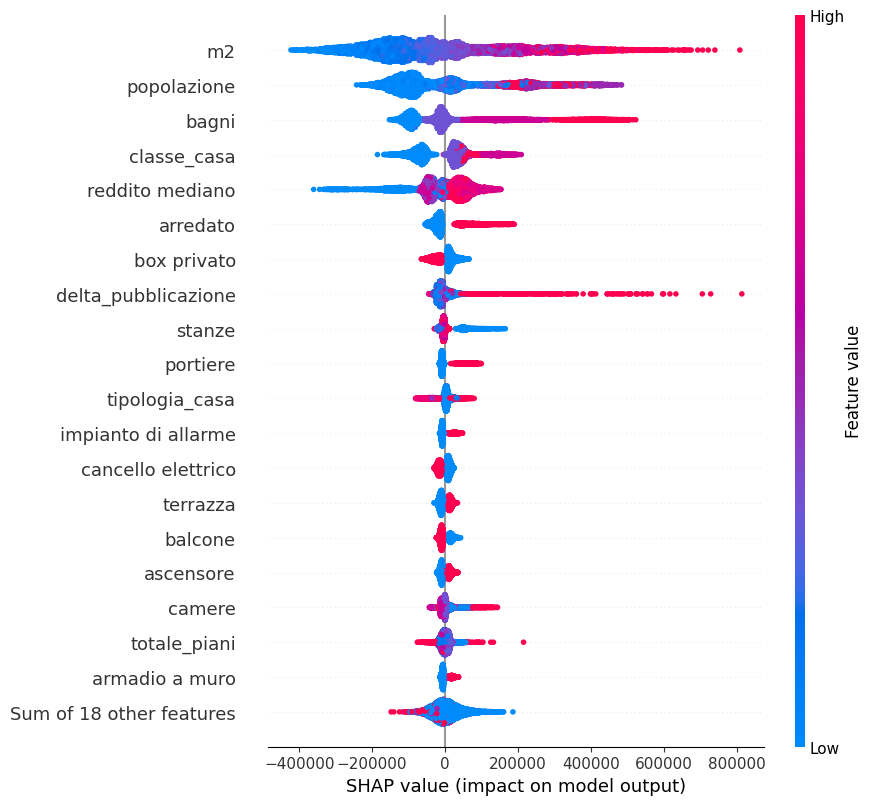

In [18]:
explainer = shap.Explainer(quantile_xgboost['xgboost_q0.95']['model'])
shap_values = explainer(train[features])
print('SHAP Values Q95')
shap.plots.beeswarm(shap_values, max_display=20)